# Домашнее задание ШАД МТС по теме Оптимизация 3

По аналогии с реализацией GD и SGD реализуйте метод инерции(Momentum), RMSprop и Adam.

Для произвольной задачи (можно сгенерировать синтетически матрицу X и вектор y) сравните результаты работы трех методов оптимизации.

Проведите эксперименты с этими методами для задач разных размерностей, сравните оценки сходимости и сделайте выводы по эмпирическим результатам о скорости и точности сходимости в зависимости от размерности и параметров моделей.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

In [3]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

In [4]:
# Метод инерции
def stochastic_gradient_descent_with_momentum(
    X: np.ndarray,  
    y: np.ndarray,
    epochs: int,  
    batch_size: int,  
    alpha: float,  
    beta: float,      
    w = None,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    v = np.zeros(m)
    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    n_iter =  0
    for _ in range(epochs):
        p = np.random.permutation(len(X))
        batch_generator = generate_batch(X[p], y[p], batch_size)

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad =  2 * X_batch.T.dot(err) / n
            v = beta * v - alpha * grad
            w_cur += v

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter +=  1
            if n_iter == max_iters:
                return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)


In [5]:
# RMSprop
def rmsprop_optimization(
    epochs: int,   
    batch_size: int,   
    alpha: float,    
    X: np.ndarray,   
    y: np.ndarray,   
    gamma = 0.99,
    w = None,
    epsilon = 1e-8, # Small constant for numerical stability
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    s = np.zeros(m)  # Initialize squared gradient history
    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    n_iter =   0
    for _ in range(epochs):
        p = np.random.permutation(len(X))
        batch_generator = generate_batch(X[p], y[p], batch_size)

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad =   2 * X_batch.T.dot(err) / n
            s = gamma * s + (1 - gamma) * np.square(grad)  # Update squared gradient history
            w_cur -= alpha * grad / (np.sqrt(s + epsilon))  # Use the RMSProp update rule

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter +=   1
            if n_iter == max_iters:
                return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)


In [6]:
# Adam
def adam_optimization(
    epochs: int,   
    batch_size: int,   
    alpha: float,    
    X: np.ndarray,   
    y: np.ndarray,   
    beta1 = 0.9,
    beta2 = 0.99,
    w = None,
    epsilon = 1e-8,
    max_iters=1000
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    v = np.zeros(m)  # Initialize squared gradient history
    g = np.zeros(m)
    w_cur = w.copy()
    w_history = [w_cur.copy()]
    err_history = []
    n_iter =   0
    for _ in range(epochs):
        p = np.random.permutation(len(X))
        batch_generator = generate_batch(X[p], y[p], batch_size)

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch
            grad =   2 * X_batch.T.dot(err) / n
            v = beta1 * v + (1 - beta1) * grad
            g = beta2 * g + (1 - beta2) * np.square(grad)
            w_cur -= alpha * v / (np.sqrt(g + epsilon))

            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter +=   1
            if n_iter == max_iters:
                return w, np.array(w_history), np.array(err_history)

    return w, np.array(w_history), np.array(err_history)

In [7]:
# Модификация функции отрисовки траекторий для нескольких оптимизаторов
def plot_weight_trajectories(X, y, w_histories: list, labels: list = ['SDG_Momentum', 'RMSprop', 'Adam'],
                             title: str = 'Weight levels and optimizer model trajectories'):
    min_weight = np.min([np.min(wh[:,  0]) for wh in w_histories]) -  1
    max_weight = np.max([np.max(wh[:,  0]) for wh in w_histories]) +  1
    w1_vals = np.linspace(min_weight, max_weight,  100)
    w2_vals = np.linspace(min_weight, max_weight,  100)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)
    
    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) **  2) /  2
    
    fig, ax = plt.subplots(figsize=(12,  8))
    ax.contour(W1, W2, J_vals, levels=30, cmap='viridis')
    
    for idx, w_history in enumerate(w_histories):
        ax.plot(w_history[:,  0], w_history[:,  1], marker='o', linestyle='-', label=labels[idx])
    
    final_point_markers = ['*', '+', 's']
    for idx, w_history in enumerate(w_histories):
        ax.scatter(w_history[-1][0], w_history[-1][1], marker=final_point_markers[idx], s=200, color='black', label=f'Final Point {labels[idx]}')
    
    ax.set_title(title)
    ax.set_xlabel('Weight  1')
    ax.set_ylabel('Weight  2')
    ax.legend()
    plt.show()


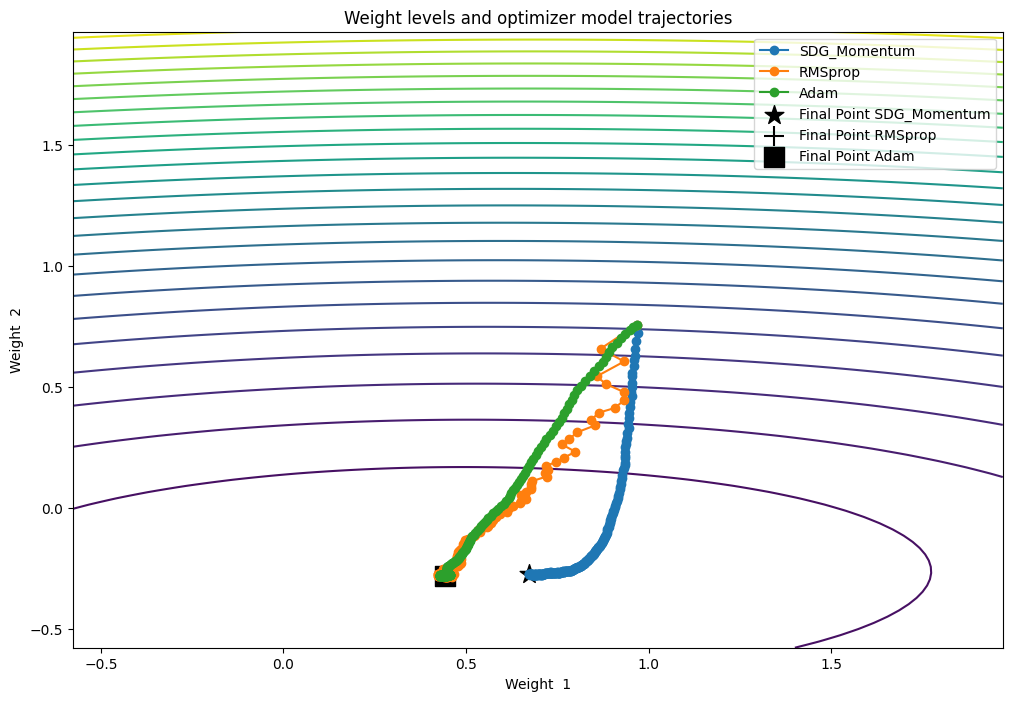

In [59]:
# Генерация выборки и построение траекторий оптимизаторов
n, m = 1000, 2

w_true = np.random.standard_normal(m)

X = np.random.uniform(-5, 5, (n, m))
X *= (np.arange(m) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n))

w_start = w = np.random.standard_normal(X.shape[1]) # начальная точка

epochs = 5          # количество эпох
batch_size = 20     # размер батча
alpha = 1e-2        # learning rate
beta = 1e-2         # второй параметр для RMSprop
max_iters = 1000    # количество итераций

sgd_w_m, sgd_w_m_history, _ = stochastic_gradient_descent_with_momentum(X=X,
                                                                        y=y,
                                                                        epochs=epochs,
                                                                        batch_size=batch_size,
                                                                        alpha=alpha,
                                                                        beta=beta,
                                                                        max_iters=max_iters,
                                                                        w=w_start)
rmsp_w, rmsp_w_history, _ = rmsprop_optimization(X=X,
                                                 y=y,
                                                 epochs=epochs,
                                                 batch_size=batch_size,
                                                 alpha=alpha,
                                                 max_iters=max_iters,
                                                 w=w_start)
adam_w, adam_w_history, _ = adam_optimization(X=X,
                                              y=y,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              alpha=alpha,
                                              max_iters=max_iters,
                                              w=w_start)
plot_weight_trajectories(X, y, [sgd_w_m_history, rmsp_w_history, adam_w_history])


**Выводы:** В данной работе была выполнена реализация трех методов оптимизации по аналогии с лекционной частью:
- SGD с инерцией (Momentum),
- RMSprop,
- Adam,
а также доработана функция отображения траекторий оптимизаторов.

Результаты проведенных исследований показали различные результативности моделей в зависимости от исходных параметров, напрмер:
- при уменьшении количества итераций SGD_M справляется хуже, не успевая сходиться к минимуму;
- Adam показывает более сглаженный путь оптимизации, в сравнении с RMSprop из-за наличия импульса, а также быстрее достигает сходимости к минимуму;
- при увеличении learning rate SGD_M показывает лучшие результаты, чем RMSprop или Adam, т.к. при большом шаге обучения два последних начинают блуждать вокруг минимума;
- однако чрезмерное уменьшение learning rate негативно сказывается на всех трех моделях - из-за маленького шага оптимизаторы не успевают достигнуть точки минимума и приходится значительно увелиивать количество итераций или количество эпох для достижения сходимости.